In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import rl

matplotlib = rl.plot_utils.set_mpl_defaults(matplotlib)

# Task Setup

In [2]:
task_vars = rl.task.TaskVars()
task_vars.n_trials = 100
task_vars.n_blocks = 1
task = rl.task.Task(task_vars=task_vars)
task

Task with the task rules:
  {'0': {'p_r_0': 0.2, 'p_r_1': 0.8, 'a_correct': [1]}, '1': {'p_r_0': 0.8, 'p_r_1': 0.2, 'a_correct': [0]}}

# Agent

In [3]:
agent_vars = rl.agent.AgentVars()
agent = rl.agent.Agent(agent_vars=agent_vars)
agent

Dual learning rate agent with
  alpha_win = 0.7
  alpha_loss = 0.5
  beta = 1

# Interaction

Let the agent perform the task.

In [4]:
np.random.seed(1)
df = rl.interaction.agent_task_interaction(task, agent)
df.head()

,trial,block,rule,p_r_0,p_r_1,r,a,corr,p_a0,p_a1,v_a_0,v_a_1,ll
0,0.0,0.0,1.0,0.8,0.2,1.0,0.0,1.0,0.500000,0.500000,0.70000,0.0,-0.693147
1,1.0,0.0,1.0,0.8,0.2,1.0,0.0,1.0,0.668188,0.331812,0.91000,0.0,-0.403186
2,2.0,0.0,1.0,0.8,0.2,1.0,0.0,1.0,0.713000,0.287000,0.97300,0.0,-0.338274
3,3.0,0.0,1.0,0.8,0.2,1.0,0.0,1.0,0.725717,0.274283,0.99190,0.0,-0.320595
4,4.0,0.0,1.0,0.8,0.2,1.0,0.0,1.0,0.729463,0.270537,0.99757,0.0,-0.315447


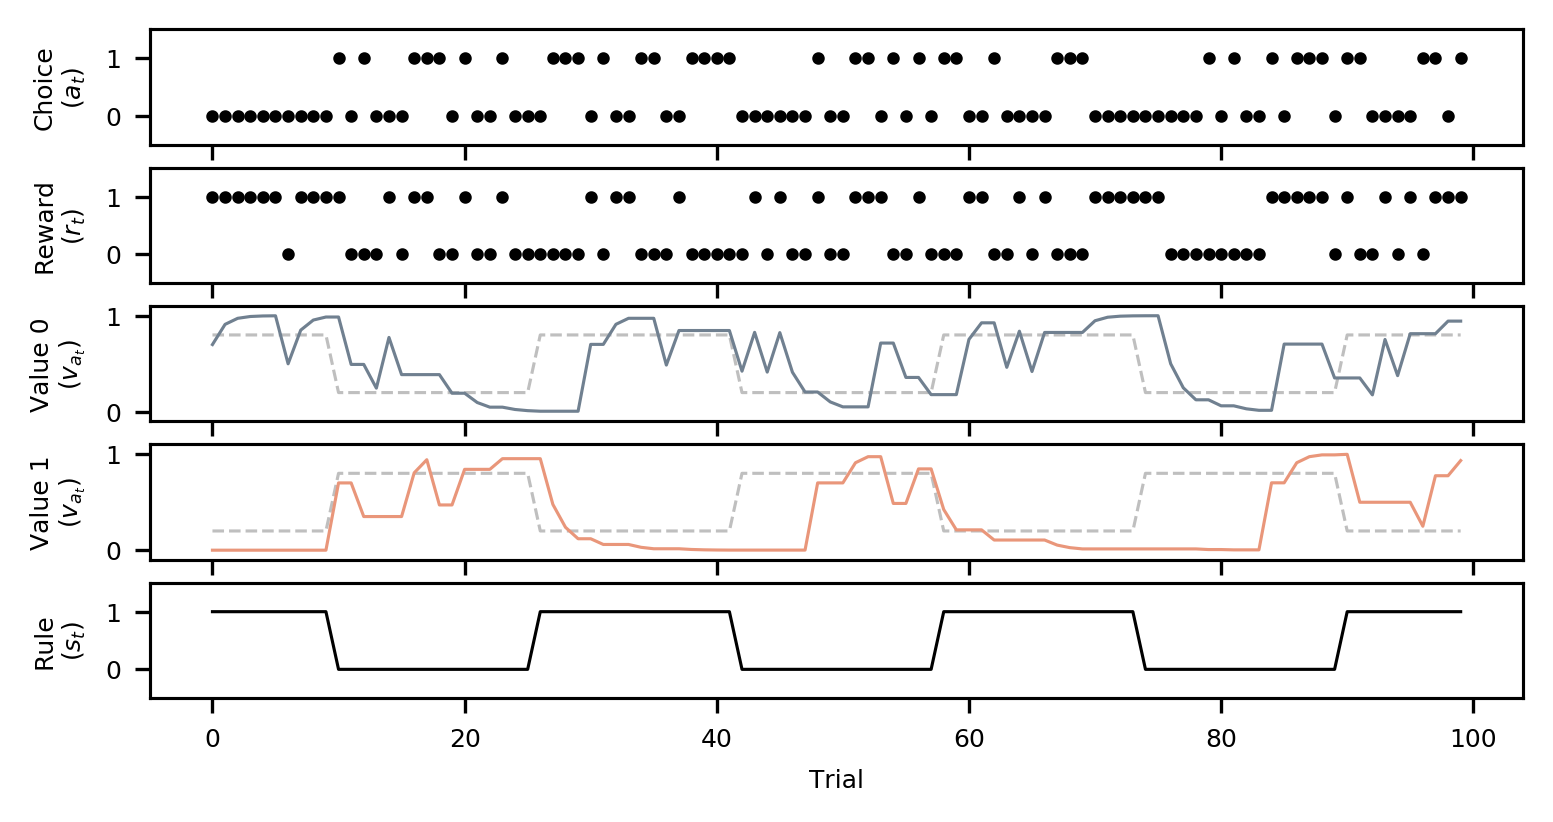

In [5]:
rl.plots.plot_data(data=df);